<a href="https://colab.research.google.com/github/pritika-vig/modeling-adrs/blob/main/feature_engineering/clinical_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Install dependencies
!pip install scikit-learn
!pip install nltk
!pip install wordcloud
!pip install --upgrade google-cloud-bigquery


In [ ]:

import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from google.cloud import bigquery
from google.colab import auth
from nltk.corpus import stopwords

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
notes_path = '/content/drive/My Drive/physionet/NOTEEVENTS.csv.gz'
df_notes = pd.read_csv(notes_path, compression='gzip', low_memory=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Loaded notes:", df_notes.shape)

Loaded notes: (2083180, 11)


In [ ]:
auth.authenticate_user()
client = bigquery.Client(project="mit-mlhc-class-450518")  # 🔁 Replace this


In [ ]:
# ICU stays
icu_query = """
SELECT SUBJECT_ID, HADM_ID, ICUSTAY_ID, INTIME
FROM `physionet-data.mimiciii_clinical.icustays`
"""
df_icu = client.query(icu_query, location="US").to_dataframe()

# Diagnoses
diag_query = """
SELECT SUBJECT_ID, HADM_ID, ICD9_CODE
FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
"""
df_diag = client.query(diag_query, location="US").to_dataframe()

print("ICU stays:", df_icu.shape)
print("Diagnoses:", df_diag.shape)

ICU stays: (61532, 4)
Diagnoses: (651047, 3)


In [ ]:
df_notes['CHARTTIME'] = pd.to_datetime(df_notes['CHARTTIME'], errors='coerce')
df_icu['INTIME'] = pd.to_datetime(df_icu['INTIME'], errors='coerce')

df = pd.merge(df_notes, df_icu, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
df = df[(df['CHARTTIME'] >= df['INTIME']) &
        (df['CHARTTIME'] <= df['INTIME'] + pd.Timedelta(days=3))]

print("Filtered ICU notes:", df.shape)

Filtered ICU notes: (638966, 13)


In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['CLEANED_TEXT'] = df['TEXT'].fillna('').apply(clean_text)

# Aggregate by ICU stay
df_agg = df.groupby(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])['CLEANED_TEXT'].apply(lambda x: ' '.join(x)).reset_index()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop_words = list(stopwords.words('english'))
vectorizer = CountVectorizer(stop_words=stop_words, binary=True, max_features=5000)
X = vectorizer.fit_transform(df_agg['CLEANED_TEXT'])
feature_names = vectorizer.get_feature_names_out()
X_df = pd.DataFrame(X.toarray(), columns=feature_names)

In [ ]:
# STEP 6: Add ADR Labels from Diagnoses
ADR_ICD9_CODES = set([
    '9950','9952','9954','9956','E850','E851','E852','E853','E854','E855',
    'E856','E858','E859','E930','E931','E932','E933','E934','E935','E936',
    'E937','E938','E939','E940','E941','E942','E943','E944','E945','E946',
    'E947','E948','E949','27669','36255','6923','6930','7080'
])

df_diag['ICD9_CODE'] = df_diag['ICD9_CODE'].astype(str)
df_adr = df_diag[df_diag['ICD9_CODE'].isin(ADR_ICD9_CODES)].copy()
df_adr['ADR'] = True

df_adr_flag = df_adr[['SUBJECT_ID', 'HADM_ID', 'ADR']].drop_duplicates()
df_agg = pd.merge(df_agg, df_adr_flag, on=['SUBJECT_ID', 'HADM_ID'], how='left')
df_agg['ADR'] = df_agg['ADR'].fillna(False)

<ipython-input-15-e4b05277c3e8>:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_agg['ADR'] = df_agg['ADR'].fillna(False)


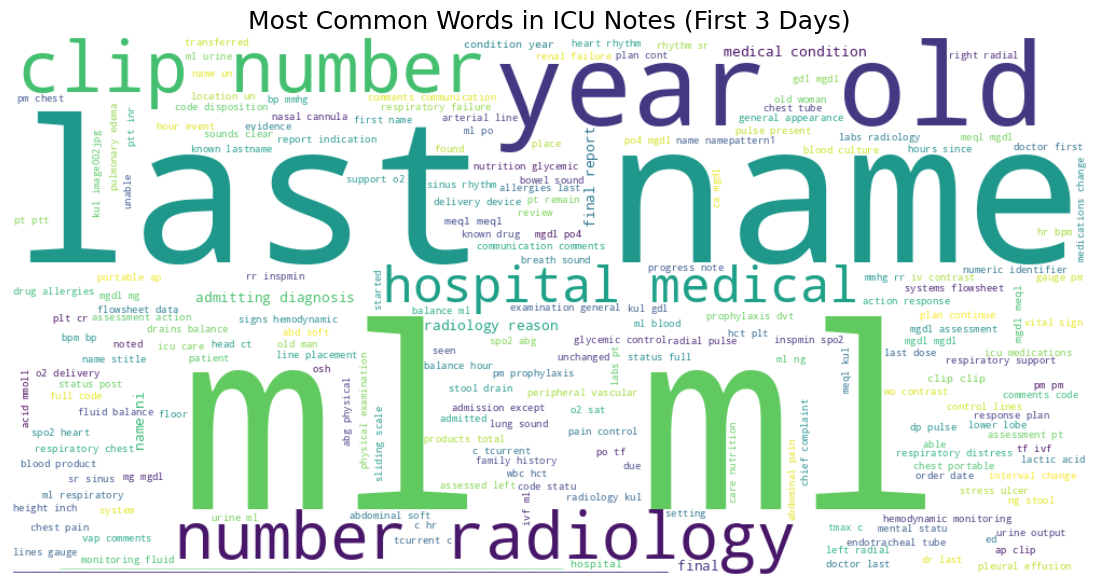

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Use the same aggregated and cleaned text
all_text = ' '.join(df_agg['CLEANED_TEXT'].tolist())

# Create word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white',
                      stopwords=stop_words, max_words=200).generate(all_text)

# Display it
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in ICU Notes (First 3 Days)", fontsize=18)
plt.show()

In [ ]:
# Split aggregated note data
df_adr = df_agg[df_agg['ADR'] == True]
df_nonadr = df_agg[df_agg['ADR'] == False]
from collections import Counter

stop_words_set = set(stop_words)  # for fast lookup

def word_counts(text_series):
    counter = Counter()
    for doc in text_series:
        words = doc.split()
        words = [w for w in words if w not in stop_words_set]  # ← filter here
        counter.update(words)
    return counter

# Word frequency counters
adr_counts = word_counts(df_adr['CLEANED_TEXT'])
nonadr_counts = word_counts(df_nonadr['CLEANED_TEXT'])

# Total documents in each group (to normalize)
n_adr = len(df_adr)
n_nonadr = len(df_nonadr)
# All unique words across both groups
all_words = set(adr_counts.keys()).union(set(nonadr_counts.keys()))

# Build comparison table
rows = []
for word in all_words:
    freq_adr = adr_counts[word] / n_adr if n_adr else 0
    freq_nonadr = nonadr_counts[word] / n_nonadr if n_nonadr else 0
    diff = freq_adr - freq_nonadr
    rows.append((word, freq_adr, freq_nonadr, diff))

freq_df = pd.DataFrame(rows, columns=['word', 'freq_adr', 'freq_nonadr', 'difference'])
freq_df['abs_diff'] = freq_df['difference'].abs()
# Top words most overrepresented in either class
top_diff_words = freq_df.sort_values(by='abs_diff', ascending=False).head(30)
top_diff_words

,word,freq_adr,freq_nonadr,difference,abs_diff
358102,ml,21.686103,15.217536,6.468567,6.468567
89859,pm,15.572400,10.043090,5.529311,5.529311
396222,rash,4.939747,0.658049,4.281699,4.281699
310618,right,13.422741,9.434696,3.988044,3.988044
298274,reason,9.481050,5.738019,3.743031,3.743031
360438,mgdl,11.266278,7.564590,3.701688,3.701688
196633,______________________________________________...,9.193392,5.540235,3.653157,3.653157
466894,left,12.802721,9.297559,3.505162,3.505162
351703,assessment,11.566569,8.088374,3.478196,3.478196
206001,tube,8.438290,5.074296,3.363993,3.363993


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Use ADR label
y = df_agg['ADR'].astype(int)

# Train sparse linear SVM for feature selection
svm = LinearSVC(C=0.01, penalty='l1', dual=False, max_iter=5000)
svm.fit(X_df, y)

# Select informative features
selector = SelectFromModel(svm, prefit=True)
X_reduced = selector.transform(X_df)
selected_features = X_df.columns[selector.get_support()]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
X_reduced_df = pd.DataFrame(X_reduced, columns=selected_features)

# Merge identifiers and label
X_reduced_df['SUBJECT_ID'] = df_agg['SUBJECT_ID'].values
X_reduced_df['ICUSTAY_ID'] = df_agg['ICUSTAY_ID'].values
X_reduced_df['ADR'] = df_agg['ADR'].values

# Verify ICUSTAY_ID exists
assert 'ICUSTAY_ID' in X_reduced_df.columns, "Missing ICUSTAY_ID column!"

# Optional: check for duplicates or missing
print("Rows:", len(X_reduced_df))
print("Unique ICUSTAY_IDs:", X_reduced_df['ICUSTAY_ID'].nunique())

Rows: 57075
Unique ICUSTAY_IDs: 57075


In [ ]:
import numpy as np
import pandas as pd

# Get feature names and coefficients
coef = svm.coef_.flatten()
feature_names = X_df.columns

# Create a DataFrame of word + weight
coef_df = pd.DataFrame({
    'word': feature_names,
    'weight': coef
})

# Filter to non-zero coefficients (selected features)
coef_df = coef_df[coef_df['weight'] != 0]

# Sort by importance
top_positive = coef_df.sort_values('weight', ascending=False).head(20)
top_negative = coef_df.sort_values('weight').head(20)

print("🔺 Words most associated with ADR:")
print(top_positive)

print("\n🔻 Words most associated with non-ADR:")
print(top_negative)

🔺 Words most associated with ADR:
           word    weight
599    benadryl  0.062269
3658       rash  0.054632
3673   reaction  0.049631
318    allergic  0.015315
4603      torso  0.015193
4671      trunk  0.013139
1320    devices  0.012845
191     abscess  0.012839
3447        pre  0.012300
3718        red  0.010625
1313  developed  0.010603
3162   overload  0.009476
1560  effusions  0.008593
4401        svc  0.007401
2954      newly  0.006808
1182   cultures  0.006296
4753         us  0.006261
1485       drug  0.006248
2567       line  0.006007
2532      level  0.005788

🔻 Words most associated with non-ADR:
            word    weight
2870      murmur -0.017228
3554          pt -0.015296
2359      intact -0.010787
2155          hr -0.010328
3353        plan -0.008235
871          chf -0.007776
2960          ni -0.007221
4597        tone -0.007042
644        blood -0.006888
883      chronic -0.006474
753          cad -0.005753
2678         man -0.005616
4016  secretions -0.005004
173

In [ ]:
leaky_words = ['benadryl', 'rash', 'reaction', 'allergic', 'allergy', 'red', 'hives']
X_df_filtered = X_df.drop(columns=[w for w in leaky_words if w in X_df.columns])
svm = LinearSVC(C=0.01, penalty='l1', dual=False, max_iter=5000)
svm.fit(X_df_filtered, y)

selector = SelectFromModel(svm, prefit=True)
X_reduced = selector.transform(X_df_filtered)
selected_features = X_df_filtered.columns[selector.get_support()]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
# Get feature names and coefficients
coef = svm.coef_.flatten()
feature_names = X_df_filtered.columns

# Create a DataFrame of word + weight
coef_df = pd.DataFrame({
    'word': feature_names,
    'weight': coef
})

# Filter to non-zero coefficients (selected features)
coef_df = coef_df[coef_df['weight'] != 0]

# Sort by importance
top_positive = coef_df.sort_values('weight', ascending=False).head(20)
top_negative = coef_df.sort_values('weight').head(20)

print("🔺 Words most associated with ADR:")
print(top_positive)

print("\n🔻 Words most associated with non-ADR:")
print(top_negative)

🔺 Words most associated with ADR:
             word    weight
4664        trunk  0.023356
4596        torso  0.018628
1289         derm  0.013820
191       abscess  0.013772
1317      devices  0.013563
1310    developed  0.012983
3443          pre  0.011293
2692       marrow  0.009343
3158     overload  0.009153
1783       fevers  0.008897
4394          svc  0.008278
1557    effusions  0.007290
4442  tachycardia  0.006770
2301    infection  0.006679
2950        newly  0.006524
226     acyclovir  0.006431
2563         line  0.005474
4767   vancomycin  0.005171
1482         drug  0.005069
653          body  0.004901

🔻 Words most associated with non-ADR:
            word    weight
3550          pt -0.016431
2295      infant -0.013224
2355      intact -0.009939
2151          hr -0.009415
868          chf -0.007674
3349        plan -0.007494
2866      murmur -0.006799
2674         man -0.006322
880      chronic -0.005306
1728   extubated -0.005256
2956          ni -0.005140
4009  secretion

In [ ]:
X_reduced_df = pd.DataFrame(X_reduced, columns=selected_features)

# Merge identifiers and label
X_reduced_df['SUBJECT_ID'] = df_agg['SUBJECT_ID'].values
X_reduced_df['ICUSTAY_ID'] = df_agg['ICUSTAY_ID'].values
X_reduced_df['ADR'] = df_agg['ADR'].values

# Verify ICUSTAY_ID exists
assert 'ICUSTAY_ID' in X_reduced_df.columns, "Missing ICUSTAY_ID column!"

# Optional: check for duplicates or missing
print("Rows:", len(X_reduced_df))
print("Unique ICUSTAY_IDs:", X_reduced_df['ICUSTAY_ID'].nunique())
print(X_reduced_df.shape)

Rows: 57075
Unique ICUSTAY_IDs: 57075
(57075, 149)


In [ ]:
output_path = '/content/drive/My Drive/clinical_notes_reduced_features.csv'
X_reduced_df.to_csv(output_path, index=False)
print(f"Saved: {output_path}")

Saved: /content/drive/My Drive/clinical_notes_reduced_features.csv
